In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform, get_transform
# from project.preprocessing import z_score_normalization, min_max_normalization
# from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
C:\Users\araza\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

cases = ds.load_raw_mri()
masks = ds.load_cmb_masks()

In [4]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 3)

In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(385, 3)

In [6]:
cases = data.mri
masks = data.masks
target = data.target

# RPN Dataloader

In [7]:
transform = NiftiToTensorTransform(target_shape = (512, 512), rpn_mode=True)

In [8]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [9]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collate_fn,
)

# ViT Dataloader

In [10]:
dset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=NiftiToTensorTransform(target_shape = (512, 512)),
    normalization=z_score_normalization,
)

# Feeder

In [11]:
resize = get_transform(
    height=100,
    width=100,
    p=1.0,
    rpn_mode=False
)

In [12]:
feeder = Feeder(resize)

In [13]:
sample = next(enumerate(dloader))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


MULTIPLE BOXES FOUND
tensor([[346., 201., 371., 227.],
        [269., 166., 298., 196.]], dtype=torch.float64)
============== FINAL BOX
tensor([269., 166., 371., 227.], dtype=torch.float64)


In [14]:
mri = sample[1][0]
bboxes = sample[1][1]
mask = dset.locate_case_by_mri(sample[1][3][0])[1]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [15]:
bboxes.shape

torch.Size([35, 1, 1, 4])

In [16]:
bboxes = bboxes.view(bboxes.shape[0], -1)

In [17]:
bboxes[(bboxes > 0).all(dim=1)]

tensor([[253., 328., 277., 353.],
        [269., 167., 297., 195.],
        [269., 166., 371., 227.],
        [345., 200., 373., 228.]], dtype=torch.float64)

In [18]:
bbox = bboxes[(bboxes > 0).all(dim=1)][2]

In [19]:
bbox = bbox.int().tolist()
bbox

[269, 166, 371, 227]

In [20]:
cmri = feeder(mri, bbox)
cmask = feeder(mask, bbox)

35


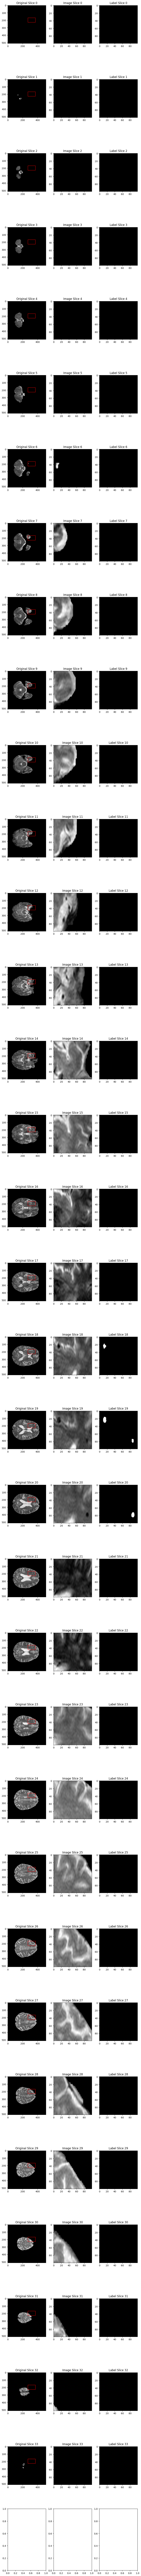

In [21]:
import matplotlib.patches as patches

num_slices = mri.shape[0]
fig, ax = plt.subplots(num_slices, 3, figsize=(10, 200))
print(num_slices)

for i in range(num_slices-1):

    ax[i, 0].imshow(mri[i].view(512, -1), cmap='gray')
    ax[i, 0].set_title(f'Original Slice {i}')
    
    ax[i, 1].imshow(cmri[i][0], cmap='gray')
    ax[i, 1].set_title(f'Image Slice {i}')
    
    ax[i, 2].imshow(cmask[i][0], cmap='gray')
    ax[i, 2].set_title(f'Label Slice {i}')
    
    rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2] - bbox[0],
        bbox[3] - bbox[1],
        linewidth=1, edgecolor='r', facecolor='none'
    )
    
    ax[i, 0].add_patch(rect)

plt.show()

In [22]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)